In [65]:
import multiprocessing as mp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import corner

import camb
import clik

In [66]:
def _MH(S, log_target, init, proposal_distribution, burn=0, thin=1):
    samples = []
    log_likelihoods = []
    current = init
    accepts = 0
    camb_fails = 0
    current_log_prob = log_target(*current)
    for s in range(S):
        proposal = proposal_distribution(current)
        U = np.random.uniform(0, 1)
        proposal_log_prob = None
        while proposal_log_prob is None: 
            try: 
                proposal_log_prob = log_target(*proposal)
            except:
                camb_fails += 1
        mh_prob = np.exp(proposal_log_prob - current_log_prob)
        if U < np.min((1, mh_prob)):
            samples.append(proposal)
            log_likelihoods.append(proposal_log_prob)
            current = proposal
            current_log_prob = proposal_log_prob
            accepts += 1
        else:
            samples.append(current)
            log_likelihoods.append(current_log_prob)
    print(f"camb fails: {camb_fails}")
    return np.array(samples)[int(burn * S)::thin], np.array(log_likelihoods)[int(burn * S)::thin], np.array(accepts) * 1. / S

In [67]:
np.hstack([np.array([1, 2, 3, 4]), np.array([8, 9])])

array([1, 2, 3, 4, 8, 9])

In [86]:
CMBlkl = clik.clik("baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22_TT.clik")
# CMBlkl = clik.clik("baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22_TT_lmax2400.clik")
# CMBlkl = clik.clik("baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22b_TTTEEE.clik")
# CMBlkl = clik.clik("baseline/plc_3.0/hi_l/plik_lite/plik_lite_v22_TT.clik")

# print(CMBlkl.get_has_cl())
# print(CMBlkl.get_lmax())
planck_nuisance_params = np.loadtxt("baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22_TT.clik.cls")[-20:]

def target(ombh2, omch2, cosmomctheta100, tau, ns, ln1e10As):
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=ombh2, omch2=omch2, cosmomc_theta=cosmomctheta100/100, tau=tau, omk=0)
    pars.InitPower.set_params(As=np.exp(ln1e10As)/1e10, ns=ns, r=0)
    pars.set_for_lmax(2550, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    
    TT = powers['total'][:2509, 0]
    # log_likelihood = CMBlkl(totCL[:2430,0]) # cutoff lmax=2400
    log_likelihood = CMBlkl(np.hstack([TT, planck_nuisance_params])) # plik default
    # log_likelihood = CMBlkl(totCL[:2510,0]) # plik_lite
    return log_likelihood[0]

#define the proposal distribution variance
# Order: ombh2, omch2, 100*cosmomctheta, tau, ns, ln(1e10*As) 
proposal_sigma_sq = 0.005*np.square(np.diag([0.00033, 0.0031, 0.00068, 0.038, 0.0094, 0.072]))

#define the proposal distribution sampler
# proposal_distribution = lambda mean: sp.stats.multivariate_normal.rvs(mean, proposal_sigma_sq**0.5, size=1)
def proposal_distribution(mean): 
    return sp.stats.multivariate_normal.rvs(mean, proposal_sigma_sq, size=1)

In [87]:
S=1_000
# init = [115,10, 2, 12, 45, 7]
init = [0.022068, 0.12029, 1.04122, 0.0925, 0.9624, 3.098]
#run sampler 2 on target distribution 1
chain1, logliks1, ar1 = _MH(S, target, init, proposal_distribution, burn=0.2, thin=1)
# chain2, ar2 = _MH(S, target, init, proposal_distribution, burn=0.2, thin=20)
# chain3, ar3 = _MH(S, target, init, proposal_distribution, burn=0.2, thin=20)
# chain4, ar4 = _MH(S, target, init, proposal_distribution, burn=0.2, thin=20)
# chain5, ar5 = _MH(S, target, init, proposal_distribution, burn=0.2, thin=20)
# samples = [chain1, chain2, chain3, chain4, chain5]
samples = [chain1]
# accept_rates = [ar1, ar2, ar3, ar4, ar5]
# print(accept_rates)
print(ar1)

camb fails: 0
0.184


In [88]:
target(*init)

-624.7659375444896

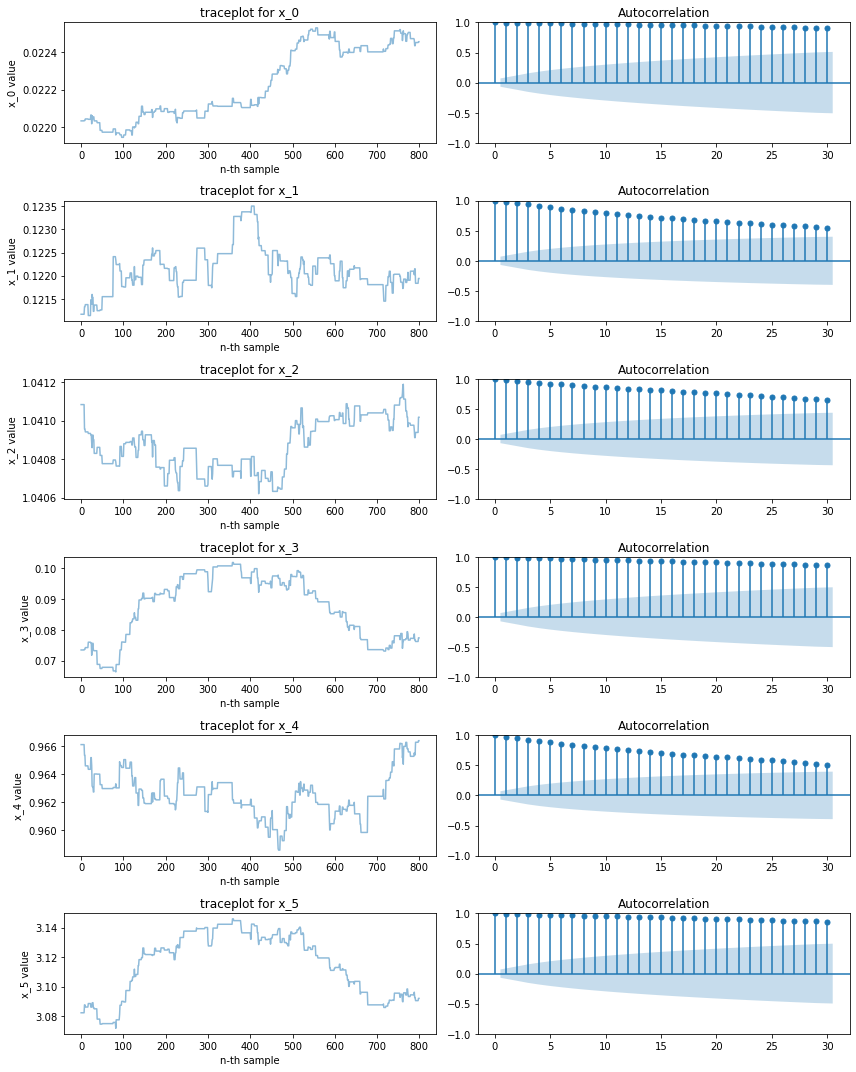

In [93]:
fig, ax = plt.subplots(6, 2, figsize=(12, 15))
for i in range(6):
    for chain in samples: 
        ax[i, 0].plot(np.arange(chain.shape[0]), chain[:, i], alpha=0.5) # plot the trace plot for x_1
        ax[i, 0].set_xlabel('n-th sample') # set x-axis label
        ax[i, 0].set_ylabel(f'x_{i} value') # set y-axis label
        ax[i, 0].set_title(f'traceplot for x_{i}') # set the title

        plot_acf(chain[:, i], ax=ax[i, 1])

plt.tight_layout() # layout the subplots nicely
plt.show() # display the figure

In [90]:
chain1

array([[0.0220346 , 0.12116671, 1.04108297, 0.07347476, 0.96611532,
        3.08231822],
       [0.0220346 , 0.12116671, 1.04108297, 0.07347476, 0.96611532,
        3.08231822],
       [0.0220346 , 0.12116671, 1.04108297, 0.07347476, 0.96611532,
        3.08231822],
       ...,
       [0.02245018, 0.12183587, 1.04093848, 0.07623608, 0.9662825 ,
        3.0905408 ],
       [0.02245469, 0.12193992, 1.0410175 , 0.07743404, 0.96639678,
        3.09208682],
       [0.02245469, 0.12193992, 1.0410175 , 0.07743404, 0.96639678,
        3.09208682]])

In [91]:
logliks1

array([-383.17964536, -383.17964536, -383.17964536, -383.17964536,
       -383.17964536, -383.17964536, -383.17964536, -383.17964536,
       -381.75839308, -381.75839308, -380.4673592 , -380.4673592 ,
       -380.4673592 , -380.4673592 , -380.4673592 , -380.4673592 ,
       -380.4673592 , -381.39174241, -381.39174241, -381.39174241,
       -381.39174241, -381.39174241, -381.39174241, -386.05036256,
       -386.05036256, -386.16644011, -381.13350687, -381.31942152,
       -381.31942152, -380.16216385, -380.16216385, -380.01582904,
       -380.01582904, -380.01582904, -380.01582904, -380.01582904,
       -380.01582904, -380.01582904, -381.5136073 , -381.5136073 ,
       -381.5136073 , -381.5136073 , -381.5136073 , -381.5136073 ,
       -381.5136073 , -381.08076261, -381.08076261, -381.08076261,
       -381.08076261, -381.08076261, -380.87342949, -380.87342949,
       -380.87342949, -380.87342949, -380.87342949, -380.87342949,
       -380.87342949, -380.87342949, -380.87342949, -380.87342

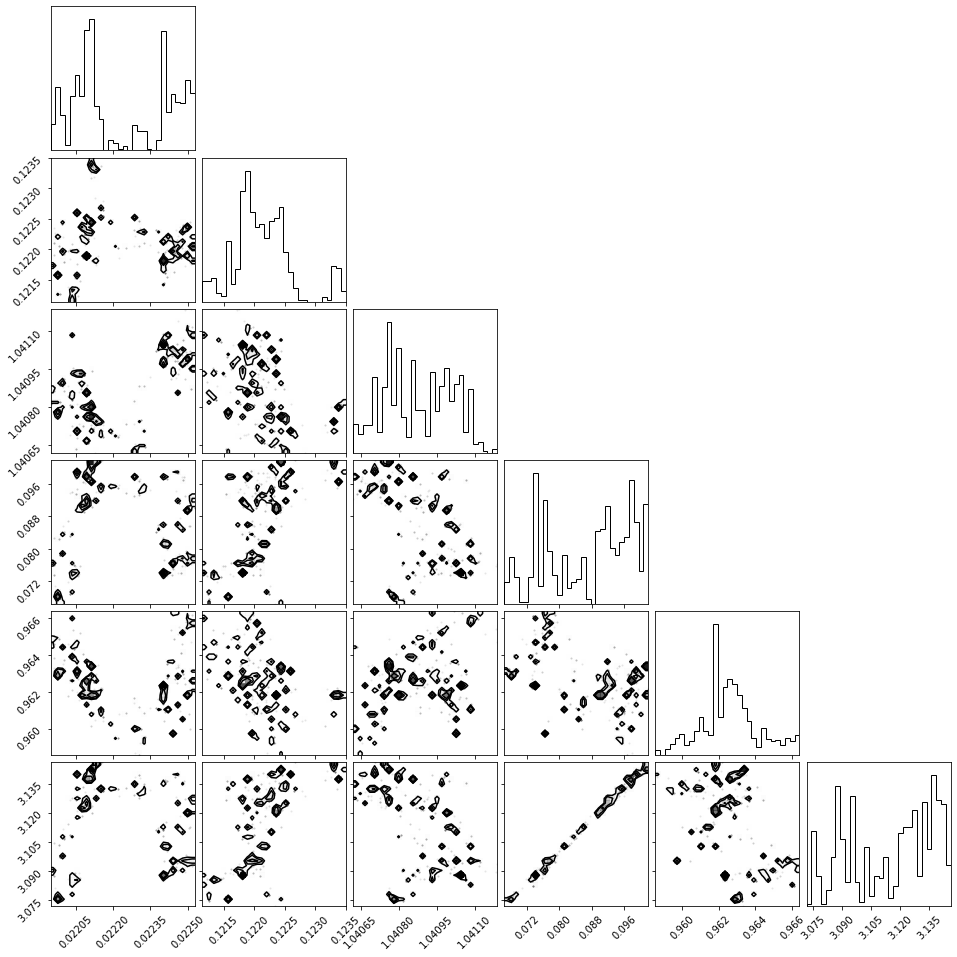

In [94]:
corner.corner(np.vstack(samples), bins=30)
plt.show()

In [11]:
def camb_cls(ombh2, omch2, cosmomctheta100, tau, ns, ln1e10As):
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=ombh2, omch2=omch2, cosmomc_theta=cosmomctheta100/100, tau=tau, omk=0)
    pars.InitPower.set_params(As=np.exp(ln1e10As)/1e10, ns=ns, r=0)
    pars.set_for_lmax(2550, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    totCL = powers['total']
    return totCL
    # log_likelihood = CMBlkl(totCL[:2529,0])
totCL = camb_cls(*init)

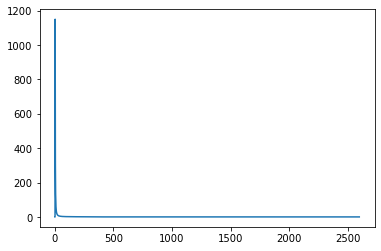

In [12]:
plt.plot(totCL[:, 0])
plt.show()

2529
2601


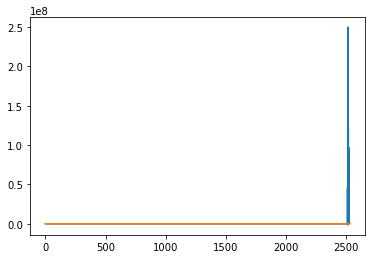

In [28]:
cls = np.loadtxt("baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22_TT.clik.cls")
lmax = len(cls)
print(lmax)
print(len(totCL[:, 0]))
norm = np.arange(lmax) * np.arange(1, lmax+1) / (2 * np.pi)
# plt.plot((cls * norm)[:-20])
plt.plot((cls * norm))
plt.plot(totCL[:2529, 0] * norm)
# plt.plot(totCL[:2529, 0] * norm - (cls * norm))
plt.show()

In [29]:
(totCL[:2529, 0] * norm).shape
(cls * norm)[:-20].shape

(2509,)

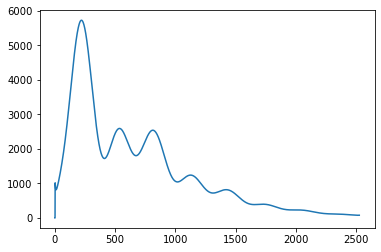

(array([-380.34102629]), array([-2.89714146e+31]), array([-5.34105308e+31]))

In [32]:
cls_suppressed = cls.copy()
cls_suppressed[-20:] = cls_suppressed[-21]
plt.plot(cls_suppressed * norm)
plt.show()
CMBlkl(cls), CMBlkl(cls_suppressed), CMBlkl(totCL[:2529, 0])


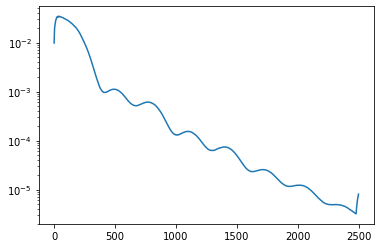

In [26]:
plt.plot(cls_suppressed[30:] - totCL[30:2529, 0])
plt.yscale("log")
plt.show()

In [34]:
print(CMBlkl(cls), CMBlkl(cls_suppressed), CMBlkl(totCL[:2529, 0]))
totCL_cp = totCL.copy()[:2529, 0]
totCL_cp[-20:] = cls[-20:]
print(CMBlkl(cls), CMBlkl(totCL_cp), CMBlkl(cls_suppressed), CMBlkl(totCL[:2529, 0]))

[-380.34102629] [-2.89714146e+31] [-5.34105308e+31]
[-380.34102629] [-624.76593754] [-2.89714146e+31] [-5.34105308e+31]


In [53]:
print(CMBlkl(cls[:2430]))

[-4.87999115e+30]


In [33]:
print(list(range(20))[:-4])
print(list(range(20))[-4:])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18, 19]


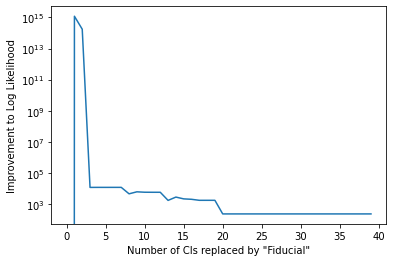

In [45]:
base_loglik = CMBlkl(cls)[0]
improvements = []
for i in range(40):
    totCL_cp = totCL.copy()[:2529, 0]
    totCL_cp[-i:] = cls[-i:]
    improvements.append(CMBlkl(totCL_cp)[0])
improvements = np.array(improvements)

plt.plot(base_loglik - improvements)
plt.yscale("log")
plt.ylabel("Improvement to Log Likelihood")
plt.xlabel("Number of Cls replaced by \"Fiducial\"")
plt.show()

In [35]:
cls_suppressed = cls.copy()
cls_suppressed[:20] = 700
CMBlkl(cls), CMBlkl(cls_suppressed)


(array([-380.34102629]), array([-380.34102629]))

In [22]:
# TT EE TE
np.hstack([totCL[:2529, 0], totCL[:2529,1], totCL[:2529, 3]]).shape

(7587,)

In [19]:
log_likelihood = CMBlkl(np.stack([totCL[:2529, 0], totCL[:2529,1], totCL[:2529, 3]])) # plik default


Exception: Bad shape (expecting (-1,7574) got (3,2529))

In [25]:
cls_ttteee = np.loadtxt("baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22b_TTTEEE.clik.cls")
cls_ttteee.shape

(7574,)

In [27]:
2510*3

7530

In [95]:
import pickle

with open("planck_scratch_chains.pkl", "rb") as f:
    data = pickle.load(f)

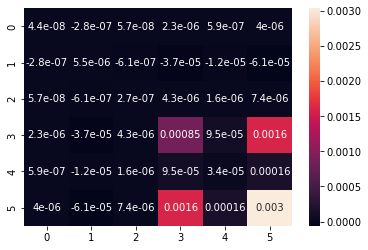

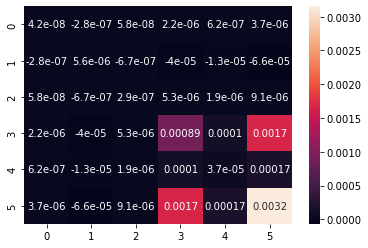

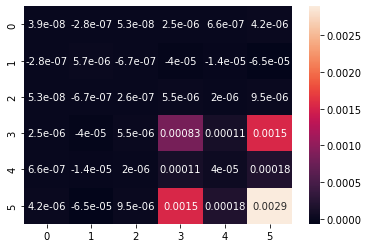

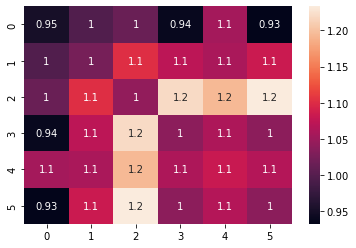

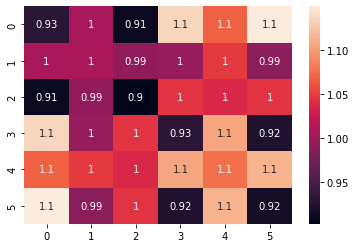

In [114]:
with open("planck_chains_run2.pkl", "rb") as f:
    data2 = pickle.load(f)

sns.heatmap(np.cov(np.vstack(data2["samples"]).T), annot=True)
plt.show()

# sns.heatmap(0.005*np.square(np.diag([0.00033, 0.0031, 0.00068, 0.038, 0.0094, 0.072])), annot=True)
# plt.show()

with open("planck_chains_run3.pkl", "rb") as f: 
    data3 = pickle.load(f)
sns.heatmap(np.cov(np.vstack(data3["samples"]).T), annot=True)
plt.show()

with open("planck_chains_run4.pkl", "rb") as f: 
    data4 = pickle.load(f)
sns.heatmap(np.cov(np.vstack(data4["samples"]).T), annot=True)
plt.show()

sns.heatmap(np.cov(np.vstack(data3["samples"]).T) / np.cov(np.vstack(data2["samples"]).T), annot=True)
plt.show()

sns.heatmap(np.cov(np.vstack(data4["samples"]).T) / np.cov(np.vstack(data3["samples"]).T), annot=True)
plt.show()

In [110]:
np.vstack(data3["samples"] + data2["samples"]).shape

(9000, 6)

In [111]:
np.vstack(data3["samples"]).shape, np.vstack(data2["samples"]).shape

((4500, 6), (4500, 6))

In [122]:
data_to_save = {
    "samples": data2["samples"] + data3["samples"] + data4["samples"],
    "log_likelihoods": data2["log_likelihoods"] + data3["log_likelihoods"] + data4["log_likelihoods"],
    "accept_rates": data2["accept_rates"] + data3["accept_rates"] + data4["accept_rates"]
}

with open("planck_chains_run2_run3_run4.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

In [151]:
def gelman_rubin(chains): 
    n_chains = len(chains)
    n_samples = len(chains[0])
    chain_means = np.mean(chains, axis=1)
    grand_mean = np.mean(chain_means, axis=0)
    B = n_samples / (n_chains - 1) * np.diag((chain_means - grand_mean).T @ (chain_means - grand_mean))
    W = np.mean(np.var(chains, axis=1, ddof=1), axis=0)

    return ((n_samples - 1)/n_samples * W + B / n_samples) / W

gelman_rubin(data_to_save["samples"])

array([1.00377285, 1.01546926, 1.01043519, 1.02792468, 1.01556492,
       1.02746197])